In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AI_Club

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AI_Club


In [15]:
!pip install simplet5

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 26.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


In [2]:
import numpy as np
import pandas as pd
import transformers
from transformers import AutoModel, BertTokenizerFast, AdamW
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [3]:
data = pd.read_csv('data.csv')

# Train-Validation-Test set split into 70:15:15 ratio
data['Summary'] = data.apply(lambda row: row['Headline'] + ' ' + row['Body'] if pd.notnull(row['Body']) else row['Headline'], axis=1)

train_text, temp_text, train_labels, temp_labels = train_test_split(data['Summary'], data['Label'], random_state=2018, test_size=0.3, stratify=data['Label'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size=0.5, stratify=temp_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Average: 495.7063435495367
Standard Deviation: 528.8893323336728


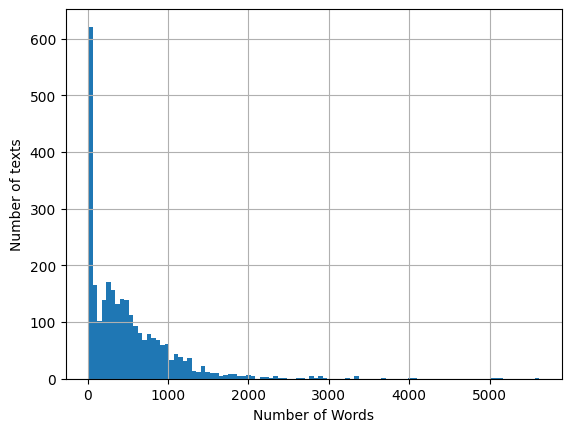

In [4]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

seq_len = [len(text.split()) for text in train_text]
pd.Series(seq_len).hist(bins = 100)
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

import statistics

average = statistics.mean(seq_len)
sd = statistics.stdev(seq_len)

print(f"Average: {average}")
print(f"Standard Deviation: {sd}")

In [5]:
import math
MAX_LENGTH = math.floor(math.sqrt(average))
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [6]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

for param in bert.parameters():
    param.requires_grad = False

In [7]:
train_seq.shape

torch.Size([2806, 22])

In [8]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
      # print(sent_id.shape)
      # print(mask.shape)
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

model = BERT_Arch(bert)
optimizer = AdamW(model.parameters(), lr = 1e-5)
cross_entropy  = nn.NLLLoss()
epochs = 5

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
def train():

  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):
    if step % 10 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

  avg_loss = total_loss / len(train_dataloader)

  return avg_loss

In [10]:
def evaluate():

  model.eval()
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    batch = [t for t in batch]
    sent_id, mask, labels = batch

    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()

  avg_loss = total_loss / len(val_dataloader)

  return avg_loss

In [11]:
best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    valid_loss = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    10  of     88.
  Batch    20  of     88.
  Batch    30  of     88.
  Batch    40  of     88.
  Batch    50  of     88.
  Batch    60  of     88.
  Batch    70  of     88.
  Batch    80  of     88.

Training Loss: 0.692
Validation Loss: 0.682

 Epoch 2 / 5
  Batch    10  of     88.
  Batch    20  of     88.
  Batch    30  of     88.
  Batch    40  of     88.
  Batch    50  of     88.
  Batch    60  of     88.
  Batch    70  of     88.
  Batch    80  of     88.

Training Loss: 0.684
Validation Loss: 0.676

 Epoch 3 / 5
  Batch    10  of     88.
  Batch    20  of     88.
  Batch    30  of     88.
  Batch    40  of     88.
  Batch    50  of     88.
  Batch    60  of     88.
  Batch    70  of     88.
  Batch    80  of     88.

Training Loss: 0.677
Validation Loss: 0.669

 Epoch 4 / 5
  Batch    10  of     88.
  Batch    20  of     88.
  Batch    30  of     88.
  Batch    40  of     88.
  Batch    50  of     88.
  Batch    60  of     88.
  Batch    70  of     88.
  B

In [13]:
path = 'c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

with torch.no_grad():
  preds = model(test_seq, test_mask)

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       321
           1       0.71      0.52      0.60       281

    accuracy                           0.67       602
   macro avg       0.68      0.66      0.66       602
weighted avg       0.68      0.67      0.67       602



In [52]:
def pick_first_n_words(string, max_words=22):
    split_str = string.split()
    return " ".join(split_str[:min(len(split_str), max_words)])
map_label = {1:'real', 0: 'fake'}
train_df = pd.DataFrame({'source_text': train_text.apply(lambda x: pick_first_n_words(x)), 'target_text': train_labels.apply(lambda x: map_label[x])})
val_df = pd.DataFrame({'source_text': val_text.apply(lambda x: pick_first_n_words(x)), 'target_text': val_labels.apply(lambda x: map_label[x])})
test_df = pd.DataFrame({'source_text': test_text.apply(lambda x: pick_first_n_words(x)), 'target_text': test_labels.apply(lambda x: map_label[x])})

In [53]:
from simplet5 import SimpleT5
model = SimpleT5()

# Load the pre-trained T5 model
model.from_pretrained(model_type="t5", model_name="t5-small")

# Train the model
model.train(
    train_df = train_df,
    eval_df = val_df,
    source_max_token_len = 22,
    target_max_token_len = 10,
    batch_size = 32,
    max_epochs = 5,
    use_gpu=False
)

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [54]:
model.load_model("t5", "/content/drive/MyDrive/AI_Club/outputs/simplet5-epoch-4-train-loss-0.1494-val-loss-0.1096", use_gpu=False)

In [55]:
predictions = []
for index, row in test_df.iterrows():
    prediction = model.predict(row['source_text'])[0]
    predictions.append(prediction)

In [56]:
print(predictions)

['real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real',

In [57]:
from sklearn.metrics import accuracy_score

actual_labels = test_df['target_text']
accuracy = accuracy_score(actual_labels, predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.9352159468438538
